In [1]:
import os, random
import numpy as np
import torch

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Resampling
Read Tamil from Kaggle input and save 16k audio to working directory

In [2]:

import os, glob
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm
import random

SRC_ROOT = "/kaggle/input/datasets/tahmimahoque/depression-det/Depression_det/Depression_det/Tamil/Tamil"
DST_ROOT = "/kaggle/working/Tamil_16k"
TARGET_SR = 16000

pairs = [
    (os.path.join(SRC_ROOT, "Depressed", "Train_set"),
     os.path.join(DST_ROOT, "Depressed", "Train_set")),
    (os.path.join(SRC_ROOT, "Non-depressed", "Train_set"),
     os.path.join(DST_ROOT, "Non-depressed", "Train_set")),
]

os.makedirs(DST_ROOT, exist_ok=True)

total = converted = same_sr = failed = 0

for src_dir, dst_dir in pairs:

    if not os.path.isdir(src_dir):
        print("Missing:", src_dir)
        continue

    os.makedirs(dst_dir, exist_ok=True)

    files = glob.glob(os.path.join(src_dir, "**", "*.wav"), recursive=True) + \
            glob.glob(os.path.join(src_dir, "**", "*.WAV"), recursive=True)

    print(f"Found {len(files)} files in {src_dir}")
    total += len(files)

    for fp in tqdm(files, desc=f"Resampling {os.path.basename(src_dir)}"):
        try:
            y, sr = librosa.load(fp, sr=None, mono=True)

            # Trim silence
            y, _ = librosa.effects.trim(y, top_db=30)

            if y.size == 0:
                failed += 1
                continue

            #  Resample if needed
            if sr != TARGET_SR:
                y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
                converted += 1
            else:
                same_sr += 1

            # RMS normalize
            rms = float(np.sqrt(np.mean(y**2) + 1e-8))
            y = y / max(rms, 1e-3)
            y = np.clip(y, -1.0, 1.0)

            out_path = os.path.join(dst_dir, os.path.basename(fp))
            sf.write(out_path, y, TARGET_SR, subtype="PCM_16")

        except Exception as e:
            failed += 1

print("\n==== DONE ====")
print("Total files:", total)
print("Already 16k:", same_sr)
print("Resampled:", converted)
print("Failed:", failed)

#  Quick verify SR
check = glob.glob(os.path.join(DST_ROOT, "**", "*.wav"), recursive=True)
print("Saved files:", len(check))

sample = random.sample(check, min(20, len(check))) if check else []

srs = []
for fp in sample:
    _, sr = librosa.load(fp, sr=None, mono=True)
    srs.append(sr)

if srs:
    vals, cnts = np.unique(srs, return_counts=True)
    print("SR counts:", dict(zip(vals.tolist(), cnts.tolist())))

print(" Output folder:", DST_ROOT)

Found 454 files in /kaggle/input/datasets/tahmimahoque/depression-det/Depression_det/Depression_det/Tamil/Tamil/Depressed/Train_set


Resampling Train_set: 100%|██████████| 454/454 [00:22<00:00, 19.79it/s]


Found 920 files in /kaggle/input/datasets/tahmimahoque/depression-det/Depression_det/Depression_det/Tamil/Tamil/Non-depressed/Train_set


Resampling Train_set: 100%|██████████| 920/920 [00:22<00:00, 41.48it/s]



==== DONE ====
Total files: 1374
Already 16k: 454
Resampled: 920
Failed: 0
Saved files: 1374
SR counts: {16000: 20}
 Output folder: /kaggle/working/Tamil_16k


# Build Metadata

Create CSV from resampled Tamil_16k with labels and speaker IDs

In [3]:

import os, glob, re
import pandas as pd

DATA_ROOT_16K = "/kaggle/working/Tamil_16k"
dep_train = os.path.join(DATA_ROOT_16K, "Depressed", "Train_set")
nd_train  = os.path.join(DATA_ROOT_16K, "Non-depressed", "Train_set")

def extract_speaker_from_path(fp: str) -> str:
    base = os.path.splitext(os.path.basename(fp))[0]

    # Non-depressed: 
    m = re.match(r"^(ND\d+)", base, flags=re.IGNORECASE)
    if m:
        return m.group(1).upper()

    # Depressed: 
    if base.startswith("D_"):
        rest = base[2:]                 # remove D_
        tok  = rest.split("_")[0]       # first token after D_
        tok  = re.sub(r"[-_][0-9a-zA-Z]+$", "", tok)  # remove trailing 
        return tok.upper()

    # fallback
    tok = base.split("_")[0]
    tok = re.sub(r"[-_][0-9a-zA-Z]+$", "", tok)
    return tok.upper()

rows = []

def collect(folder, label):
    if not os.path.isdir(folder):
        print(f" Missing folder: {folder}")
        return

    wavs = glob.glob(os.path.join(folder, "**", "*.wav"), recursive=True) + \
           glob.glob(os.path.join(folder, "**", "*.WAV"), recursive=True)

    print(f"{folder} -> {len(wavs)} files")

    for f in wavs:
        fname = os.path.splitext(os.path.basename(f))[0]
        spk   = extract_speaker_from_path(f)
        rows.append({
            "file_path": f,
            "label": int(label),
            "fname": fname,
            "speaker": spk
        })

collect(dep_train, 1)
collect(nd_train, 0)

df = pd.DataFrame(rows)

print("\n Total samples:", len(df))
if len(df):
    print(" Label counts:\n", df["label"].value_counts())
    print(" Unique speakers:", df["speaker"].nunique())
    print(" Speakers per label:\n", df.groupby("label")["speaker"].nunique())

OUT_CSV = os.path.join(DATA_ROOT_16K, "tamil_trainval_16k.csv")
df.to_csv(OUT_CSV, index=False)
print("\n Saved:", OUT_CSV)

df.head()

/kaggle/working/Tamil_16k/Depressed/Train_set -> 454 files
/kaggle/working/Tamil_16k/Non-depressed/Train_set -> 920 files

 Total samples: 1374
 Label counts:
 label
0    920
1    454
Name: count, dtype: int64
 Unique speakers: 44
 Speakers per label:
 label
0     5
1    39
Name: speaker, dtype: int64

 Saved: /kaggle/working/Tamil_16k/tamil_trainval_16k.csv


,file_path,label,fname,speaker
0,/kaggle/working/Tamil_16k/Depressed/Train_set/...,1,D_S00_35-2,S00
1,/kaggle/working/Tamil_16k/Depressed/Train_set/...,1,D_S00_38-4,S00
2,/kaggle/working/Tamil_16k/Depressed/Train_set/...,1,D_S00_27-2,S00
3,/kaggle/working/Tamil_16k/Depressed/Train_set/...,1,D_S00_07-2,S00
4,/kaggle/working/Tamil_16k/Depressed/Train_set/...,1,D_S00_52-4,S00


# Speaker Sanity Check

In [5]:
import pandas as pd
import re

# Kaggle paths
CSV_PATH = "/kaggle/working/Tamil_16k/tamil_trainval_16k.csv"
df = pd.read_csv(CSV_PATH)

print(" Loaded:", CSV_PATH)
print("Total rows:", len(df))
print("Unique speakers:", df["speaker"].nunique())
print("Speakers per label:\n", df.groupby("label")["speaker"].nunique())

# 1) Mixed-label speakers check (speaker leakage risk)
mix = df.groupby("speaker")["label"].nunique()
mixed = mix[mix > 1]
print("\nMixed-label speakers (should be 0):", len(mixed))
if len(mixed):
    print(mixed.head(20))

# 2) Show top speakers by #files (helps spot parsing bug)
print("\nTop 15 speakers by file-count:")
print(df["speaker"].value_counts().head(15))

# 3) Pattern check: 
def is_ok_spk(s):
    s = str(s)
    if re.fullmatch(r"ND\d+", s): return True
    if re.fullmatch(r"S\d+", s): return True          # S00, S01...
    if re.fullmatch(r"F\d+", s): return True          # F2006...
    if re.fullmatch(r"[A-Z]\d+", s): return True      # A1 type (just in case)
    return False

bad = df[~df["speaker"].apply(is_ok_spk)]
print("\nSuspicious speaker IDs:", bad["speaker"].nunique())
print(bad[["fname","speaker","label"]].head(30))

# 4) Depressed files 
bad_dep = df[(df["label"]==1) & (df["speaker"].astype(str).str.contains(r"[-_]", regex=True))]
print("\nDepressed speakers containing '-' or '_' (should be 0 ideally):", bad_dep["speaker"].nunique())
print(bad_dep[["fname","speaker"]].head(30))

 Loaded: /kaggle/working/Tamil_16k/tamil_trainval_16k.csv
Total rows: 1374
Unique speakers: 44
Speakers per label:
 label
0     5
1    39
Name: speaker, dtype: int64

Mixed-label speakers (should be 0): 0

Top 15 speakers by file-count:
speaker
S00       241
ND1       184
ND5       184
ND4       184
ND2       184
ND3       184
A00        80
F10018      4
F20011      4
F10017      4
F2001       4
F10015      4
F10010      4
F1008       4
F20012      4
Name: count, dtype: int64

Suspicious speaker IDs: 0
Empty DataFrame
Columns: [fname, speaker, label]
Index: []

Depressed speakers containing '-' or '_' (should be 0 ideally): 0
Empty DataFrame
Columns: [fname, speaker]
Index: []


# # Speaker Split

Speaker-stratified train/val split

In [6]:

import numpy as np
import pandas as pd
import os

IN_CSV  = "/kaggle/working/Tamil_16k/tamil_trainval_16k.csv"
OUT_CSV = "/kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv"

assert os.path.isfile(IN_CSV), f" Missing IN_CSV: {IN_CSV}. Run BLOCK 1 first."

df = pd.read_csv(IN_CSV)

mix = df.groupby("speaker")["label"].nunique()
mixed = mix[mix > 1]
assert len(mixed) == 0, f" Mixed-label speakers found: {len(mixed)}. Fix speaker parsing first."

# 1) Speaker -> label 
spk_label = df.groupby("speaker")["label"].agg(lambda x: int(x.value_counts().idxmax())).reset_index()
dep_spk = spk_label[spk_label["label"] == 1]["speaker"].tolist()
nd_spk  = spk_label[spk_label["label"] == 0]["speaker"].tolist()

print(" Dep speakers:", len(dep_spk), "| ND speakers:", len(nd_spk))

# 2) Choose VAL speakers
rng = np.random.default_rng(42)

n_nd_val = 1 if len(nd_spk) >= 2 else len(nd_spk)
val_frac_dep = 0.20
n_dep_val = int(round(len(dep_spk) * val_frac_dep))
n_dep_val = max(2, n_dep_val) if len(dep_spk) >= 2 else len(dep_spk)

val_nd  = set(rng.choice(nd_spk,  size=n_nd_val, replace=False).tolist()) if n_nd_val > 0 else set()
val_dep = set(rng.choice(dep_spk, size=n_dep_val, replace=False).tolist()) if n_dep_val > 0 else set()

val_spk = val_nd | val_dep

# 3) Assign split
df["split"] = "train"
df.loc[df["speaker"].isin(val_spk), "split"] = "val"

# 4) Checks
print("\n Split counts:\n", df["split"].value_counts())
print("\n Label counts by split:\n", df.groupby(["split","label"]).size())
print("\n Speakers by split:\n", df.groupby("split")["speaker"].nunique())

train_spk = set(df[df["split"]=="train"]["speaker"])
val_spk2  = set(df[df["split"]=="val"]["speaker"])
overlap = train_spk & val_spk2
print("\n Speaker overlap (MUST be empty):", overlap)

assert len(overlap) == 0, " Speaker leakage: overlap is NOT empty!"

# 5) Save
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
df.to_csv(OUT_CSV, index=False)
print("\n Saved:", OUT_CSV)

print("\n VAL speakers (for record):", sorted(list(val_spk2)))

 Dep speakers: 39 | ND speakers: 5

 Split counts:
 split
train    1158
val       216
Name: count, dtype: int64

 Label counts by split:
 split  label
train  0        736
       1        422
val    0        184
       1         32
dtype: int64

 Speakers by split:
 split
train    35
val       9
Name: speaker, dtype: int64

 Speaker overlap (MUST be empty): set()

 Saved: /kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv

 VAL speakers (for record): ['F10011', 'F10015', 'F10021', 'F10022', 'F1007', 'F2001', 'F20011', 'F20015', 'ND1']


# MFCC

In [7]:
import os, random
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Kaggle paths
CSV_PATH = "/kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv"
SAVE_DIR = "/kaggle/working/models_tamil"
os.makedirs(SAVE_DIR, exist_ok=True)

assert os.path.isfile(CSV_PATH), f" Missing CSV: {CSV_PATH}. Run BLOCK 1→3 first."

df = pd.read_csv(CSV_PATH)


def extract_mfcc(file_path, target_sr=16000, n_mfcc=40, max_len=320):
    y, sr = librosa.load(file_path, sr=target_sr, mono=True)

    
    y, _ = librosa.effects.trim(y, top_db=30)
    if y is None or len(y) == 0:
        y = np.zeros(int(target_sr * 0.5), dtype=np.float32)  # 0.5s silence fallback

    mfcc = librosa.feature.mfcc(y=y, sr=target_sr, n_mfcc=n_mfcc)  # [n_mfcc, T]

  
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)

    T = mfcc.shape[1]
    if T < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - T)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc.astype(np.float32)

class TamilMFCCDataset(Dataset):
    def __init__(self, df, split):
        self.df = df[df["split"] == split].reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = extract_mfcc(row["file_path"])
        y = int(row["label"])
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

train_ds = TamilMFCCDataset(df, "train")
val_ds   = TamilMFCCDataset(df, "val")

def seed_worker(worker_id):
    s = SEED + worker_id
    np.random.seed(s); random.seed(s)

g = torch.Generator()
g.manual_seed(SEED)

# WeightedRandomSampler for TRAIN only (handles skew better than only class weights)
train_labels = df[df["split"]=="train"]["label"].astype(int).values
class_counts = np.bincount(train_labels, minlength=2)          # [count0, count1]
class_weights = 1.0 / np.maximum(class_counts, 1)             # inverse freq
sample_weights = class_weights[train_labels]                  # per sample weight

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    sampler=sampler,              # use sampler instead of shuffle
    shuffle=False,
    num_workers=2,                
    worker_init_fn=seed_worker,
    generator=g,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=2,                
    worker_init_fn=seed_worker,
    generator=g,
    pin_memory=True
)

class MFCC_CNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [B,1,40,320]
        x = self.features(x)
        return self.classifier(x)

model = MFCC_CNN().to(device)

# Loss: still keep class weights (fine), even though sampler already helps
cw = compute_class_weight("balanced", classes=np.array([0,1]), y=train_labels)
cw = torch.tensor(cw, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# LR scheduler improves stability
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)

def eval_macro_f1(model):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            pred = torch.argmax(logits, dim=1)
            ys.extend(y.cpu().numpy().tolist())
            ps.extend(pred.cpu().numpy().tolist())
    return f1_score(ys, ps, average="macro")


best_f1 = -1.0
best_state = None
patience = 6
bad = 0
EPOCHS = 30

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    val_f1 = eval_macro_f1(model)
    scheduler.step(val_f1)

    print(f"Epoch {epoch:02d} | train_loss={total_loss/len(train_loader):.4f} | val_macroF1={val_f1:.4f}")

    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

# Safety: best_state fallback
if best_state is None:
    print(" No improvement detected; saving last epoch weights.")
else:
    model.load_state_dict(best_state)

print(" Best MFCC val macro-F1:", best_f1)

mfcc_path = os.path.join(SAVE_DIR, "mfcc_cnn_tamil_16k_stratspk.pt")
torch.save(model.state_dict(), mfcc_path)
print(" Saved:", mfcc_path)

Epoch 01 | train_loss=0.5841 | val_macroF1=0.1805
Epoch 02 | train_loss=0.3904 | val_macroF1=0.7859
Epoch 03 | train_loss=0.1994 | val_macroF1=0.8344
Epoch 04 | train_loss=0.1586 | val_macroF1=0.8345
Epoch 05 | train_loss=0.1256 | val_macroF1=0.8522
Epoch 06 | train_loss=0.1173 | val_macroF1=0.8951
Epoch 07 | train_loss=0.1163 | val_macroF1=0.8522
Epoch 08 | train_loss=0.0970 | val_macroF1=0.9382
Epoch 09 | train_loss=0.1003 | val_macroF1=0.8583
Epoch 10 | train_loss=0.1058 | val_macroF1=0.9042
Epoch 11 | train_loss=0.0826 | val_macroF1=0.9489
Epoch 12 | train_loss=0.0882 | val_macroF1=0.8403
Epoch 13 | train_loss=0.1039 | val_macroF1=0.8838
Epoch 14 | train_loss=0.0825 | val_macroF1=0.9489
Epoch 15 | train_loss=0.0652 | val_macroF1=0.8973
Epoch 16 | train_loss=0.0641 | val_macroF1=0.9410
Epoch 17 | train_loss=0.0824 | val_macroF1=0.9113
Early stopping.
 Best MFCC val macro-F1: 0.9488555643251776
 Saved: /kaggle/working/models_tamil/mfcc_cnn_tamil_16k_stratspk.pt


In [8]:
import os
from IPython.display import FileLink, display


model_path = "/kaggle/working/models_tamil/mfcc_cnn_tamil_16k_stratspk.pt"

assert os.path.isfile(model_path), f" Model not found: {model_path}"

print("Model ready:", model_path)
display(FileLink(model_path)) 

Model ready: /kaggle/working/models_tamil/mfcc_cnn_tamil_16k_stratspk.pt


/kaggle/working/models_tamil/mfcc_cnn_tamil_16k_stratspk.pt

In [9]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GT_CSV    = "/kaggle/input/datasets/tahmimahoque/tamil-test/Tamil_GT.xlsx - tam.csv"
MODEL_PATH = "/kaggle/working/models_tamil/mfcc_cnn_tamil_16k_stratspk.pt"
SEARCH_ROOT = "/kaggle/input"   # search wavs anywhere in kaggle input

assert os.path.isfile(GT_CSV), f" Missing GT csv: {GT_CSV}"
assert os.path.isfile(MODEL_PATH), f" Missing MFCC model: {MODEL_PATH}"

gt = pd.read_csv(GT_CSV)
assert {"filename","label"}.issubset(gt.columns), f" Need columns filename,label; got {gt.columns.tolist()}"

# labels: D->1, ND->0
gt["label_num"] = gt["label"].map({"D": 1, "ND": 0})
if gt["label_num"].isna().any():
    bad = gt[gt["label_num"].isna()][["filename","label"]].head(10)
    raise ValueError(f" Unknown labels found. Examples:\n{bad}")

targets = set(gt["filename"].astype(str).str.lower().tolist())

found = {}
for root, dirs, files in os.walk(SEARCH_ROOT):
    for fn in files:
        low = fn.lower()
        if low in targets:  # exact filename match
            found[low] = os.path.join(root, fn)

print(f" Found audio: {len(found)}/{len(gt)}")
if len(found) < len(gt):
    missing = [f for f in gt["filename"].tolist() if str(f).lower() not in found]
    print(" Missing examples (first 20):", missing[:20])

# If no audio found, stop early (no point running model)
assert len(found) > 0, (
    " No matching wav found in /kaggle/input. "
    "We need to add the dataset that contains t1.wav, t2.wav, ... to this notebook."
)


def extract_mfcc(file_path, target_sr=16000, n_mfcc=40, max_len=320):
    y, _ = librosa.load(file_path, sr=target_sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=30)

    if y is None or len(y) == 0:
        y = np.zeros(int(target_sr * 0.5), dtype=np.float32)

    mfcc = librosa.feature.mfcc(y=y, sr=target_sr, n_mfcc=n_mfcc)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)

    T = mfcc.shape[1]
    if T < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - T)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc.astype(np.float32)


class MFCC_CNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        return self.classifier(x)

model = MFCC_CNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

y_true, y_pred = [], []
missing_audio = 0

with torch.no_grad():
    for _, row in gt.iterrows():
        key = str(row["filename"]).lower()
        if key not in found:
            missing_audio += 1
            continue

        fp = found[key]
        x = torch.from_numpy(extract_mfcc(fp)).unsqueeze(0).to(device)  # [1,40,320]
        logits = model(x)
        pred = int(torch.argmax(logits, dim=1).item())

        y_true.append(int(row["label_num"]))
        y_pred.append(pred)

print("Missing audio skipped:", missing_audio)
print("\n MFCC CLASSIFICATION REPORT (TEST)")
print(classification_report(y_true, y_pred, digits=4, target_names=["ND(0)", "D(1)"]))

 Found audio: 160/160
Missing audio skipped: 0

 MFCC CLASSIFICATION REPORT (TEST)
              precision    recall  f1-score   support

       ND(0)     0.7018    1.0000    0.8247        80
        D(1)     1.0000    0.5750    0.7302        80

    accuracy                         0.7875       160
   macro avg     0.8509    0.7875    0.7775       160
weighted avg     0.8509    0.7875    0.7775       160



# Wav2Vec2

In [10]:
import os, random
import numpy as np
import pandas as pd
import torch, librosa
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    Wav2Vec2FeatureExtractor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Kaggle paths
CSV_PATH = "/kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv"
assert os.path.isfile(CSV_PATH), f" Missing CSV: {CSV_PATH}. Run BLOCK 1→3 first."

df = pd.read_csv(CSV_PATH)

W2V2_DIR = "/kaggle/working/wav2vec2_tamil_16k_stratspk"
os.makedirs(W2V2_DIR, exist_ok=True)


feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    sampling_rate=16000
)


class TamilW2V2Dataset(Dataset):
    def __init__(self, df, split):
        self.df = df[df["split"] == split].reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio, _ = librosa.load(row["file_path"], sr=16000, mono=True)
        audio, _ = librosa.effects.trim(audio, top_db=30)
        if audio is None or len(audio) == 0:
            audio = np.zeros(int(16000 * 0.5), dtype=np.float32)  # 0.5s fallback
        return {"input_values": audio, "labels": int(row["label"])}

train_ds = TamilW2V2Dataset(df, "train")
val_ds   = TamilW2V2Dataset(df, "val")

def collate_fn(batch):
    inputs = [b["input_values"] for b in batch]
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    feats = feature_extractor(inputs, sampling_rate=16000, padding=True, return_tensors="pt")
    feats["labels"] = labels
    return feats


train_labels = df[df["split"]=="train"]["label"].astype(int).values
cw = compute_class_weight("balanced", classes=np.array([0,1]), y=train_labels)
cw = torch.tensor(cw, dtype=torch.float32)  # keep CPU; move inside loss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        w = cw.to(logits.device)
        loss = torch.nn.functional.cross_entropy(logits, labels, weight=w)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, (tuple, list)):
        logits = logits[0]
    preds = np.argmax(logits, axis=1)
    return {"f1": f1_score(labels, preds, average="macro")}

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    num_labels=2,
    problem_type="single_label_classification"
).to(device)


for p in model.wav2vec2.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

args_stage1 = TrainingArguments(
    output_dir=os.path.join(W2V2_DIR, "stage1"),

    # HF version-safe: some versions use evaluation_strategy
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,

    learning_rate=5e-5,
    num_train_epochs=8,
    warmup_steps=50,
    weight_decay=0.01,

    fp16=True,
    max_grad_norm=1.0,
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    seed=SEED,
    remove_unused_columns=False
)

trainer1 = WeightedTrainer(
    model=model,
    args=args_stage1,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer1.train()
print(" Stage1 best F1:", trainer1.state.best_metric)

for p in model.wav2vec2.parameters():
    p.requires_grad = False

for layer in model.wav2vec2.encoder.layers[-2:]:
    for p in layer.parameters():
        p.requires_grad = True

for p in model.classifier.parameters():
    p.requires_grad = True

args_stage2 = TrainingArguments(
    output_dir=os.path.join(W2V2_DIR, "stage2"),

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,

    learning_rate=1e-5,
    num_train_epochs=8,
    warmup_steps=30,
    weight_decay=0.01,

    fp16=False,                 #  stability fix
    max_grad_norm=1.0,
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    seed=SEED,
    remove_unused_columns=False
)

trainer2 = WeightedTrainer(
    model=model,
    args=args_stage2,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer2.train()
print(" Stage2 best F1:", trainer2.state.best_metric)

FINAL_DIR = os.path.join(W2V2_DIR, "final")
os.makedirs(FINAL_DIR, exist_ok=True)
trainer2.model.save_pretrained(FINAL_DIR)
feature_extractor.save_pretrained(FINAL_DIR)
print(" Saved FINAL W2V2:", FINAL_DIR)

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/422 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-xls-r-300m
Key                          | Status     | 
-----------------------------+------------+-
project_hid.bias             | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
project_q.weight             | UNEXPECTED | 
project_hid.weight           | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
quantizer.weight_proj.bias   | UNEXPECTED | 
projector.weight             | MISSING    | 
projector.bias               | MISSING    | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,F1
1,1.377445,0.732292,0.169429
2,1.317038,0.717086,0.248389
3,1.211592,0.680204,0.412111
4,1.136489,0.619760,0.594648
5,1.032616,0.587912,0.648690
6,1.003026,0.581541,0.648690
7,0.932726,0.606039,0.590869


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 Stage1 best F1: 0.6486898154124177


Epoch,Training Loss,Validation Loss,F1
1,0.992047,0.645755,0.530999
2,0.908761,0.688552,0.431978
3,0.818890,0.751537,0.371104


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 Stage2 best F1: 0.5309987988542918


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 Saved FINAL W2V2: /kaggle/working/wav2vec2_tamil_16k_stratspk/final


In [11]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
from sklearn.metrics import classification_report
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GT_CSV     = "/kaggle/input/datasets/tahmimahoque/tamil-test/Tamil_GT.xlsx - tam.csv"
FINAL_DIR  = "/kaggle/working/wav2vec2_tamil_16k_stratspk/final"
SEARCH_ROOT = "/kaggle/input"   # search wavs anywhere in kaggle input

assert os.path.isfile(GT_CSV), f" Missing GT csv: {GT_CSV}"
assert os.path.isdir(FINAL_DIR), f" Missing W2V2 model dir: {FINAL_DIR} (train+save first)"


gt = pd.read_csv(GT_CSV)
assert {"filename","label"}.issubset(gt.columns), f" Need columns filename,label; got {gt.columns.tolist()}"

# labels: D->1, ND->0
gt["label_num"] = gt["label"].map({"D": 1, "ND": 0})
if gt["label_num"].isna().any():
    bad = gt[gt["label_num"].isna()][["filename","label"]].head(10)
    raise ValueError(f" Unknown labels found. Examples:\n{bad}")

targets = set(gt["filename"].astype(str).str.lower().tolist())


found = {}
for root, dirs, files in os.walk(SEARCH_ROOT):
    for fn in files:
        low = fn.lower()
        if low in targets:  # exact filename match
            found[low] = os.path.join(root, fn)

print(f" Found audio: {len(found)}/{len(gt)}")
if len(found) < len(gt):
    missing = [f for f in gt["filename"].tolist() if str(f).lower() not in found]
    print(" Missing examples (first 20):", missing[:20])

assert len(found) > 0, (
    " No matching wav found in /kaggle/input. "
    "We need to add the dataset that contains t1.wav, t2.wav, ... to this notebook."
)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(FINAL_DIR)
model = Wav2Vec2ForSequenceClassification.from_pretrained(FINAL_DIR).to(device)
model.eval()


@torch.no_grad()
def predict_one(audio_path):
    audio, _ = librosa.load(audio_path, sr=16000, mono=True)
    audio, _ = librosa.effects.trim(audio, top_db=30)

    if audio is None or len(audio) == 0:
        audio = np.zeros(int(16000 * 0.5), dtype=np.float32)

    feats = feature_extractor([audio], sampling_rate=16000, padding=True, return_tensors="pt")
    feats = {k: v.to(device) for k, v in feats.items()}
    logits = model(**feats).logits
    return int(torch.argmax(logits, dim=1).item())

y_true, y_pred = [], []
missing_audio = 0

for _, row in gt.iterrows():
    key = str(row["filename"]).lower()
    if key not in found:
        missing_audio += 1
        continue

    fp = found[key]
    pred = predict_one(fp)

    y_true.append(int(row["label_num"]))
    y_pred.append(pred)

print("Missing audio skipped:", missing_audio)
print("\n W2V2 CLASSIFICATION REPORT (TEST)")
print(classification_report(y_true, y_pred, digits=4, target_names=["ND(0)", "D(1)"]))

 Found audio: 160/160


Loading weights:   0%|          | 0/426 [00:00<?, ?it/s]

Missing audio skipped: 0

 W2V2 CLASSIFICATION REPORT (TEST)
              precision    recall  f1-score   support

       ND(0)     1.0000    0.1500    0.2609        80
        D(1)     0.5405    1.0000    0.7018        80

    accuracy                         0.5750       160
   macro avg     0.7703    0.5750    0.4813       160
weighted avg     0.7703    0.5750    0.4813       160



# Ensemble Optimization with Threshold Adjustment

Fine-tunes MFCC + Wav2Vec2 ensemble weight and slightly increases the decision threshold to improve Non-Depressed predictions while maintaining balanced overall performance.

 Using W2V2 checkpoint: /kaggle/working/wav2vec2_tamil_16k_stratspk/stage2/checkpoint-219


Loading weights:   0%|          | 0/426 [00:00<?, ?it/s]

 VAL samples: 216
 Tuned on VAL | objective=f2: w_mfcc=0.00, thr=0.78, score=0.9938
 Threshold used for TEST: 0.81 (tuned thr=0.78 + bump=0.03)
 Found TEST audio: 160/160
Missing audio skipped: 0

 ENSEMBLE TEST REPORT | w_mfcc=0.00, thr_used=0.81
              precision    recall  f1-score   support

       ND(0)     0.9277    0.9625    0.9448        80
        D(1)     0.9610    0.9250    0.9427        80

    accuracy                         0.9437       160
   macro avg     0.9444    0.9438    0.9437       160
weighted avg     0.9444    0.9437    0.9437       160



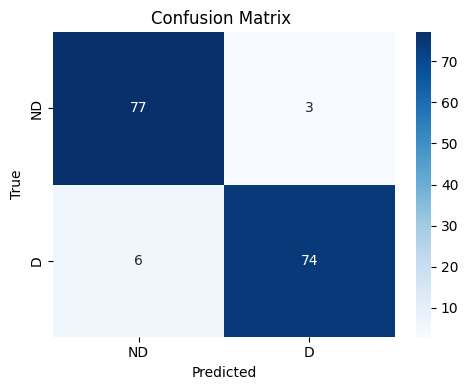

In [14]:
import os, re, glob, json
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    fbeta_score
)
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


GT_CSV      = "/kaggle/input/datasets/tahmimahoque/tamil-test/Tamil_GT.xlsx - tam.csv"
SEARCH_ROOT = "/kaggle/input"

CSV_VAL     = "/kaggle/working/Tamil_16k/tamil_trainval_16k_stratspk.csv"
MFCC_PATH   = "/kaggle/working/models_tamil/mfcc_cnn_tamil_16k_stratspk.pt"
STAGE2_DIR  = "/kaggle/working/wav2vec2_tamil_16k_stratspk/stage2"
BASE_W2V2   = "facebook/wav2vec2-xls-r-300m"

assert os.path.isfile(GT_CSV), f" Missing GT CSV: {GT_CSV}"
assert os.path.isfile(CSV_VAL), f" Missing VAL CSV: {CSV_VAL}"
assert os.path.isfile(MFCC_PATH), f" Missing MFCC model: {MFCC_PATH}"
assert os.path.isdir(STAGE2_DIR), f" Missing W2V2 stage2 dir: {STAGE2_DIR}"


def find_best_checkpoint(stage2_dir: str) -> str:
    state_path = os.path.join(stage2_dir, "trainer_state.json")
    if os.path.isfile(state_path):
        with open(state_path, "r") as f:
            state = json.load(f)
        best_ckpt = state.get("best_model_checkpoint", None)
        if best_ckpt and os.path.isdir(best_ckpt):
            return best_ckpt

    ckpts = glob.glob(os.path.join(stage2_dir, "checkpoint-*"))
    if not ckpts:
        raise FileNotFoundError(f" No checkpoints found under {stage2_dir}")

    def step_num(p):
        m = re.search(r"checkpoint-(\d+)$", p)
        return int(m.group(1)) if m else -1

    return sorted(ckpts, key=step_num)[-1]

W2V2_CKPT = find_best_checkpoint(STAGE2_DIR)
print(" Using W2V2 checkpoint:", W2V2_CKPT)


def extract_mfcc(file_path, target_sr=16000, n_mfcc=40, max_len=320):
    y, _ = librosa.load(file_path, sr=target_sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=30)
    if y is None or len(y) == 0:
        y = np.zeros(int(target_sr * 0.5), dtype=np.float32)

    mfcc = librosa.feature.mfcc(y=y, sr=target_sr, n_mfcc=n_mfcc)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)

    T = mfcc.shape[1]
    if T < max_len:
        mfcc = np.pad(mfcc, ((0,0),(0, max_len-T)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.astype(np.float32)

class MFCC_CNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)), nn.Dropout(0.25),

            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)), nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        return self.classifier(x)

mfcc_model = MFCC_CNN().to(device)
mfcc_model.load_state_dict(torch.load(MFCC_PATH, map_location=device))
mfcc_model.eval()


feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(BASE_W2V2, sampling_rate=16000)
w2v2_model = Wav2Vec2ForSequenceClassification.from_pretrained(W2V2_CKPT).to(device)
w2v2_model.eval()

softmax = torch.nn.Softmax(dim=1)

@torch.no_grad()
def mfcc_prob(file_path):
    x = torch.from_numpy(extract_mfcc(file_path)).unsqueeze(0).to(device)
    logits = mfcc_model(x)
    return softmax(logits).squeeze(0).cpu().numpy()  # [2]

@torch.no_grad()
def w2v2_prob(file_path):
    audio, _ = librosa.load(file_path, sr=16000, mono=True)
    audio, _ = librosa.effects.trim(audio, top_db=30)
    if audio is None or len(audio) == 0:
        audio = np.zeros(int(16000 * 0.5), dtype=np.float32)

    feats = feature_extractor([audio], sampling_rate=16000, padding=True, return_tensors="pt")
    feats = {k: v.to(device) for k, v in feats.items()}
    logits = w2v2_model(**feats).logits
    return softmax(logits).squeeze(0).cpu().numpy()  # [2]


df_all = pd.read_csv(CSV_VAL)
val_df = df_all[df_all["split"]=="val"].reset_index(drop=True)
val_y  = val_df["label"].astype(int).values
val_fp = val_df["file_path"].tolist()

print(" VAL samples:", len(val_fp))

val_m, val_w = [], []
for fp in val_fp:
    if not os.path.exists(fp):
        raise FileNotFoundError(f" Missing val audio: {fp}")
    val_m.append(mfcc_prob(fp))
    val_w.append(w2v2_prob(fp))

val_m = np.stack(val_m)  # [N,2]
val_w = np.stack(val_w)  # [N,2]


OBJECTIVE = "f2"  # keep your working setup
best = {"score": -1, "w": None, "t": None}

w_grid = np.linspace(0.0, 1.0, 101)
t_grid = np.linspace(0.10, 0.90, 81)

for w in w_grid:
    p = w * val_m + (1 - w) * val_w
    pD = p[:, 1]
    for t in t_grid:
        preds = (pD >= t).astype(int)

        if OBJECTIVE == "macro_f1":
            score = f1_score(val_y, preds, average="macro")
        else:
            score = fbeta_score(val_y, preds, beta=2, pos_label=1)

        if score > best["score"]:
            best.update({"score": float(score), "w": float(w), "t": float(t)})

print(f" Tuned on VAL | objective={OBJECTIVE}: w_mfcc={best['w']:.2f}, thr={best['t']:.2f}, score={best['score']:.4f}")


THR_BUMP = 0.03  
thr_used = min(0.95, best["t"] + THR_BUMP)
print(f" Threshold used for TEST: {thr_used:.2f} (tuned thr={best['t']:.2f} + bump={THR_BUMP:.2f})")

@torch.no_grad()
def ensemble_predict(file_path):
    p1 = mfcc_prob(file_path)
    p2 = w2v2_prob(file_path)

    p = best["w"] * p1 + (1 - best["w"]) * p2
    pred = int(p[1] >= thr_used)

    return pred, p

gt = pd.read_csv(GT_CSV)
gt["label_num"] = gt["label"].map({"D":1, "ND":0})
if gt["label_num"].isna().any():
    bad = gt[gt["label_num"].isna()][["filename","label"]].head(10)
    raise ValueError(f" Unknown labels found. Examples:\n{bad}")

targets = set(gt["filename"].astype(str).str.lower().tolist())

found = {}
for root, _, files in os.walk(SEARCH_ROOT):
    for fn in files:
        low = fn.lower()
        if low in targets:
            found[low] = os.path.join(root, fn)

print(f" Found TEST audio: {len(found)}/{len(gt)}")
assert len(found) > 0, " No matching test wav found in /kaggle/input"

y_true, y_pred = [], []
missing_audio = 0

for _, row in gt.iterrows():
    key = str(row["filename"]).lower()
    if key not in found:
        missing_audio += 1
        continue

    fp = found[key]
    p1 = mfcc_prob(fp)
    p2 = w2v2_prob(fp)
    p  = best["w"] * p1 + (1 - best["w"]) * p2

    pred = int(p[1] >= thr_used)   # bumped threshold
    y_true.append(int(row["label_num"]))
    y_pred.append(pred)

print("Missing audio skipped:", missing_audio)
print(f"\n ENSEMBLE TEST REPORT | w_mfcc={best['w']:.2f}, thr_used={thr_used:.2f}")
print(classification_report(y_true, y_pred, digits=4, target_names=["ND(0)", "D(1)"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["ND","D"], yticklabels=["ND","D"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix ")
plt.tight_layout()
plt.show()

# Prediction on test data (submission)

In [15]:


import os, glob
import pandas as pd

TEAM_NAME = "TriVector"
RUN = "run2"

TEST_DIR = "/kaggle/input/datasets/tahmimahoque/depression-det/Depression_det/Depression_det/Test-set-tamil/Test-set-tamil"
SAVE_DIR = "/kaggle/working/submissions"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Collect wav files
wavs = glob.glob(os.path.join(TEST_DIR, "**", "*.wav"), recursive=True) + \
       glob.glob(os.path.join(TEST_DIR, "**", "*.WAV"), recursive=True)

assert len(wavs) > 0, f" No wav found in: {TEST_DIR}"
wavs = sorted(wavs)
print(" Total test wavs:", len(wavs))

# 2) Predict (ensemble_predict MUST already be defined above)
def to_text_label(pred_int):
    return "Depressed" if int(pred_int) == 1 else "Non-depressed"

rows = []
for fp in wavs:
    pred, _ = ensemble_predict(fp)   #  ensemble
    file_id = os.path.splitext(os.path.basename(fp))[0]
    rows.append({"file_name": file_id, "labels": to_text_label(pred)})

# 3) Save CSV
csv_name = f"{TEAM_NAME}_Tamil_{RUN}.csv"
csv_path = os.path.join(SAVE_DIR, csv_name)
pd.DataFrame(rows).to_csv(csv_path, index=False)

print(" Saved Tamil RUN2 CSV:", csv_path)
print(pd.read_csv(csv_path).head())

 Total test wavs: 160
 Saved Tamil RUN2 CSV: /kaggle/working/submissions/TriVector_Tamil_run2.csv
  file_name         labels
0        t1      Depressed
1       t10  Non-depressed
2      t100      Depressed
3      t101      Depressed
4      t102      Depressed
